In [5]:
using CairoMakie
using SpecialFunctions
using Optim
using Printf
using JLD2
using LsqFit
include("AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [16]:
matern_model(ω, p) = @. p[1] * ((ω - p[2])^2 + p[3]^2)^p[4]

function normalizing_constant(α, λ)
    return beta(0.5, α-0.5)/(λ^(2α-1))
end

function power_pdf(α, x_min)
    C = (α-1) / x_min
    return (ω) -> C*(ω/x_min)^(-α)
end

function matern_pdf(α, λ, η)
    C = 1/normalizing_constant(α, λ)
    return (ω) -> C/((ω-η)^2 + λ^2)^(α)
end

function log_power_likelihood(params)
    α = params[1]
    x_min = 0.1
    return N * log(α-1) - α * sum(log.(ω)) - N*(1-α)*log(x_min)
end

function log_likelihood_function(ω)
    N = length(ω)
    function log_matern_likelihood(params)
        α, λ, η = params
        C = normalizing_constant(α, λ)
        return -α * sum(@. log(((ω - η)^2 + λ^2))) - N * log(C)
    end
    return log_matern_likelihood
end

log_likelihood_function (generic function with 1 method)

In [17]:
true_x_min = 0.1
true_alpha = 1.554
power_cdf_inv(x, alpha, x_min) = (x_min * (1-x)^(-1/(alpha - 1)))
N_samples = 16000
ω_samples = power_cdf_inv.(rand(N_samples), true_alpha, true_x_min)

initial_params = [1.3, 1, 1]
lower = [0.50001, 0, -Inf]
upper = [10, Inf, Inf]

power_func = log_likelihood_function(ω_samples)
func = TwiceDifferentiable((vars) -> -power_func(vars), initial_params);
opt = optimize(func, lower, upper, initial_params)
params = Optim.minimizer(opt)

println(-power_func(initial_params))
println(-power_func(params))
println(params)

38788.07761791568
26029.082242168442
[0.7212575076135724, 0.0646512694253982, 0.18868616604843563]


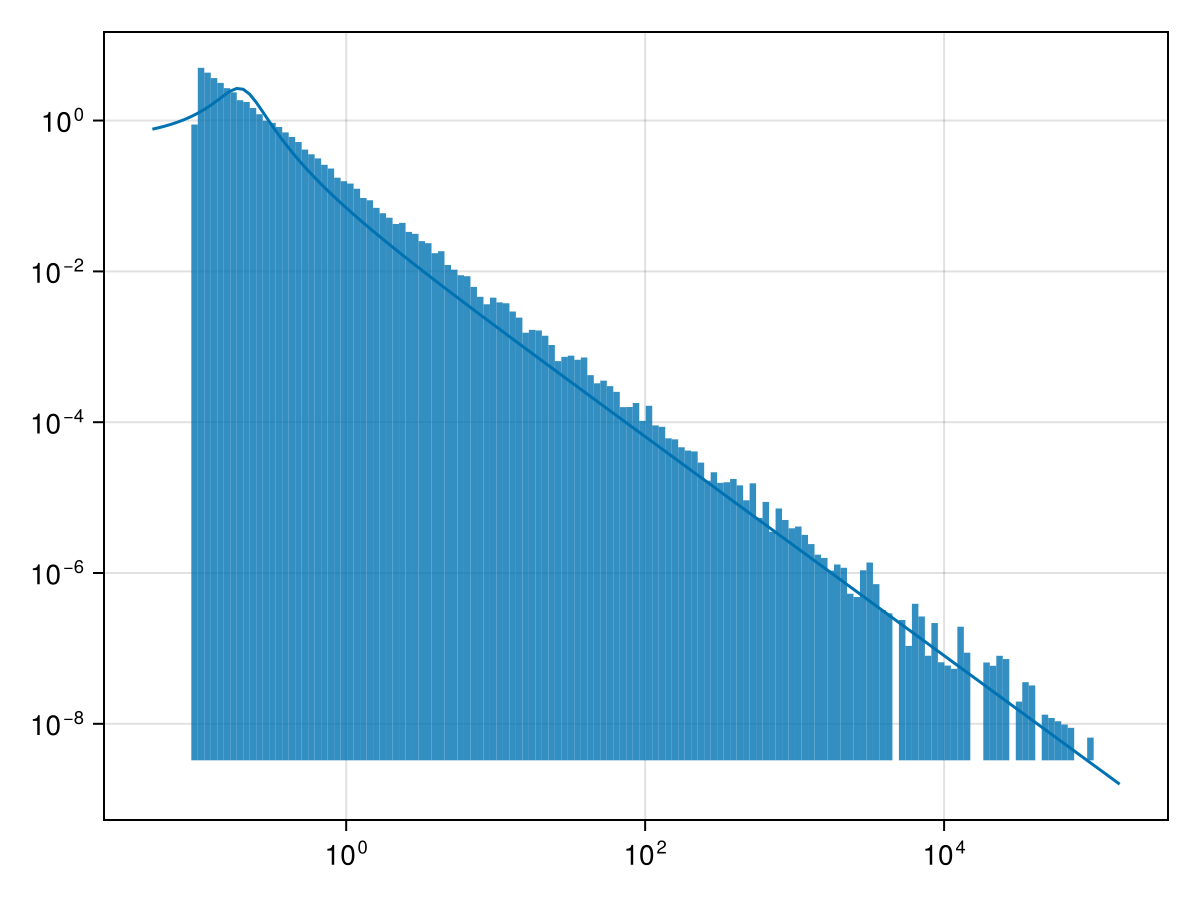

In [4]:
f = Figure()
ax = Axis(f[1,1]; xscale=log10, yscale=log10)
matern_pdf_func = matern_pdf(params...)
bins = exp.(0.01:0.1:15.0)/20
hist!(ax, ω_samples, bins=bins, normalization=:pdf)
lines!(bins, matern_pdf_func.(bins))
f

In [37]:
function estimate_pdf(data, query_point, kernel, bandwidth)
    pointwise_contribution = sample -> kernel((sample - query_point)/bandwidth)
    return sum(pointwise_contribution, data)/length(data)/bandwidth
end

function gaussian_kernel(x)
    return 1/sqrt(2π)*exp(-x^2/2)
end

function lognormal_kernel(x)
    return 1/sqrt(2π)*exp(-x^2/2)
end

function estimate_pdf(ωs)
    query_start = minimum(ωs)
    query_end = maximum(ωs)
    Npoints = length(ωs)
    
    linspace = (0:(Npoints-1))/(Npoints-1)
    #query_points = @. query_start + (query_end - query_start)*linspace
    query_points = @. exp(log(query_start) + (log(query_end) - log(query_start))*linspace)
    return estimate_pdf(ωs, query_points)
end

function estimate_pdf(ωs, query_points)
    μ_rel = sum(ωs) / length(ωs)
    σ_rel = sqrt(sum((ωs .- μ_rel).^2)/(length(ωs)-1))
    rel_bandwidth = 1.06 * σ_rel * length(ωs)^(-1/5) + 1e-2
    
    rel_pdf = estimate_pdf.(Ref(ωs), query_points, gaussian_kernel, rel_bandwidth)
    return query_points, rel_pdf
end

estimate_pdf (generic function with 3 methods)

In [6]:
run_idx = 5

data_directory = "/scratch/nad9961/swqg/58025661" # Long time run
#data_directory = "/scratch/nad9961/swqg/58031124" # Very low Froude number runs
#data_directory = "/scratch/nad9961/swqg/57615490/"
#data_directory = "/scratch/nad9961/swqg/57478238/"
#data_directory = "/scratch/nad9961/swqg/57233897/" # Matches RSW run 57233890
run_directory = data_directory * string(run_idx)
Nsnaps = count_snapshots(run_directory)
f0, Cg = read_parameters(run_directory)

time_array   = zeros(Nsnaps)
param_array  = zeros(Nsnaps, 3)
ωs           = zeros(Nsnaps, 128^2)
kernel_array = zeros(Nsnaps, 128^2)

lower_limits   = [0.5001, 0,   -Inf]
initial_params = [1.3000, 1,    2]
upper_limits   = [Inf   , Inf,  Inf]
array_idx = 1
for snap_idx=1:100:Nsnaps
    (t, x, k, u) = load_snapshot(run_directory, snap_idx)
    ω = compute_ω(k, f0, Cg)
    matern_func = log_likelihood_function(ω)
    func = TwiceDifferentiable((vars) -> -matern_func(vars), initial_params);
    opt = optimize(func, lower_limits, upper_limits, initial_params)
    params = Optim.minimizer(opt)
    ω_i, ω_pdf = estimate_pdf(ω)

    time_array[array_idx] = t
    param_array[array_idx, :] = params
    ωs[array_idx, :] = ω_i
    kernel_array[array_idx, :] = ω_pdf
    array_idx += 1
    println(@sprintf("\b\b\b\b\b\b%3.3f", snap_idx/Nsnaps))
end

0.000
0.008
0.016
0.024
0.032
0.040
0.048
0.056
0.064
0.072
0.080
0.088
0.096
0.104
0.112
0.120
0.128
0.136
0.144
0.152
0.160
0.168
0.176
0.184
0.192
0.200
0.207


InterruptException: InterruptException:

In [36]:
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, limits=((1.0, 1e2), (1e-4, 1)))
matern_pdf_func = @lift matern_pdf($params...)
bins = @lift exp.(range(log(minimum($ω)), log(maximum($ω)), length=150))
h = hist!(ax, ω, bins=[0.0, 1.0], normalization=:pdf)
@lift h.bins = $bins
y_data = @lift $matern_pdf_func.($bins)
lines!(bins, y_data)

record(fig, "wave_spreading_anim.mp4", total_indices;
        framerate = 24) do idx
    snap_idx[] = idx
    array_idx[] += 1
end

"wave_spreading_anim.mp4"

In [308]:
dx = 0.01
vals = minimum(ω):dx:1000000
sum(dx * power_pdf_func.(vals))

1.0024720625683692

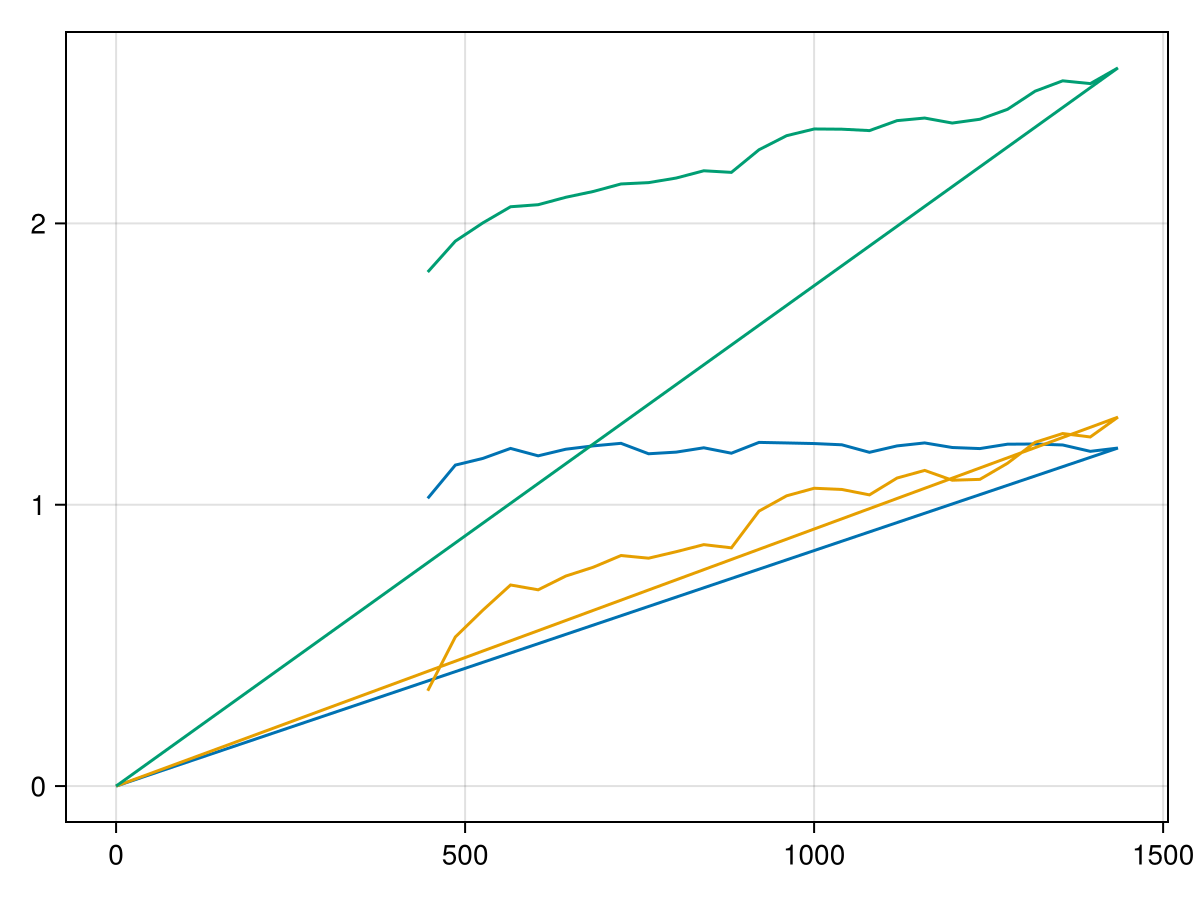

In [7]:
fig2 = Figure()
ax2 = Axis(fig2[1,1])
filter = 1:length(1:100:Nsnaps)
lines!(ax2, time_array[filter], param_array[filter,1])
lines!(ax2, time_array[filter], param_array[filter,2])
lines!(ax2, time_array[filter], param_array[filter,3])
fig2

In [7]:
matern_model(ω, p) = @. p[1]^2 * ((ω - p[2])^2 + p[3]^2)^p[4]
log_matern_model(ω, p) = @. log(p[1]^2 * ((ω - p[2])^2 + p[3]^2)^p[4])
simple_power_law(ω, p) = @. p[2] * ω + p[1]
cutoff_percentile = 0.999

function matern_estimate(ω_i, density)
    p0 = [1.0, 1.0, 10.0, -4.0]
    matern_fit = curve_fit(log_matern_model, ω_i, log.(density), p0)
end

function power_law_estimate(ω_i, density)
    power_law_p0 = [10, -1.0]
    
    min_ω = log(minimum(ω_i))
    Δω = log(maximum(ω_i)) - min_ω
    start_ω = exp(min_ω + 0.35 * Δω)
    end_ω = exp(min_ω + 0.75 * Δω)
    
    start_index = findfirst(>=(start_ω), ω_i)
    end_index = findlast(<=(end_ω), ω_i)
    power_filter = start_index:end_index
    
    power_law_fit = curve_fit(simple_power_law, log.(ω_i[power_filter]), log.(density[power_filter]), power_law_p0)
end

function matern_ML_estimate(ω)
    lower_limits   = [0.5001, 0,   -Inf]
    initial_params = [1.3000, 1,    f0]
    upper_limits   = [Inf   , Inf,  Inf]
    
    matern_func = log_likelihood_function(ω)
    func = TwiceDifferentiable((vars) -> -matern_func(vars), initial_params);
    opt = optimize(func, lower_limits, upper_limits, initial_params)
    
    params = Optim.minimizer(opt)
    return params
end

function power_law_fit_fn(t, x, k, u)
    Npackets = size(u, 1)
    rms_u = sqrt(sum(u.^2)/Npackets)
    
    ω = compute_ω(k, f0, Cg)
    cutoff_index = floor(Int, Npackets * cutoff_percentile)
    cutoff_ω = sort(ω)[1:cutoff_index]
    
    ω_i, kernel_estimate = estimate_pdf(cutoff_ω)
    full_ω_i, _ = estimate_pdf(ω)
    
    power_law_action_fit = power_law_estimate(ω_i, kernel_estimate)
    power_law_energy_fit = power_law_estimate(ω_i, ω_i .* kernel_estimate)
    return hcat(power_law_action_fit.param, power_law_energy_fit.param)
end

function matern_fit_fn(t, x, k, u)
    Npackets = size(u, 1)
    rms_u = sqrt(sum(u.^2)/Npackets)
    
    ω = compute_ω(k, f0, Cg)
    cutoff_index = floor(Int, Npackets * cutoff_percentile)
    cutoff_ω = sort(ω)[1:cutoff_index]
    
    ω_i, kernel_estimate = estimate_pdf(cutoff_ω)
    full_ω_i, _ = estimate_pdf(ω)
    
    matern_action_fit = matern_estimate(ω_i, kernel_estimate)
    matern_energy_fit = matern_estimate(ω_i, ω_i .* kernel_estimate)
    return hcat(matern_action_fit.param, matern_energy_fit.param)
end

matern_fit_fn (generic function with 1 method)

In [15]:
include("AnalysisUtils.jl")

function create_timewise_pdf_fn(bins, f0, Cg, dissapation_threshold)
    function timewise_pdf(bin_counts, prev_counts)
        return bin_counts + prev_counts
    end

    function get_bin_counts(t, x, k, u)
        ω = compute_ω(k, f0, Cg)
        ω = ω[ω .< dissapation_threshold]
        #return estimate_pdf(ω, bins)[2]
        bin_idx = ω .- bins
    end

    return timewise_pdf, get_bin_counts
end

run_idx = 15
data_directory = "/scratch/nad9961/swqg/57615490/"
#data_directory = "/scratch/nad9961/swqg/57478238/"
#data_directory = "/scratch/nad9961/swqg/57233897/" # Matches RSW run 57233890
run_directory = data_directory * string(run_idx)
Nsnaps = count_snapshots(run_directory)
f0, Cg = read_parameters(run_directory)

query_start = f0
query_end = 100*f0
bins = range(query_start, query_end, length=4000)
counts = zeros(size(bins))
reduce_fn, map_fn = create_timewise_pdf_fn(bins, f0, Cg, query_end)
time_histogram = mapreduce_snapshots(run_directory, map_fn, reduce_fn, counts)

InterruptException: InterruptException:

In [8]:
include("AnalysisUtils.jl")

run_idx = 15
data_directory = "/scratch/nad9961/swqg/57615490/"
#data_directory = "/scratch/nad9961/swqg/57478238/"
#data_directory = "/scratch/nad9961/swqg/57233897/" # Matches RSW run 57233890
run_directory = data_directory * string(run_idx)
Nsnaps = count_snapshots(run_directory)
f0, Cg = read_parameters(run_directory)

snap_filter = 1:500:Nsnaps
num_filter_snaps = length(snap_filter)

filter_fn(i, t, x, k, u) = any(i .== snap_filter)

times = zeros(num_filter_snaps)
froudes = zeros(num_filter_snaps)
power_kde_params = Array{Array{Float64, 2}, 1}(undef, num_filter_snaps)
matern_kde_params = Array{Array{Float64, 2}, 1}(undef, num_filter_snaps)
matern_ml_params = zeros(num_filter_snaps, 3)

time_fn(t, x, k, u) = t

mapfilter_snapshots(run_directory, power_law_fit_fn, filter_fn, power_kde_params)
mapfilter_snapshots(run_directory, power_law_fit_fn, filter_fn, power_kde_params)
mapfilter_snapshots(run_directory, time_fn, filter_fn, times)

LoadError: syntax: invalid keyword argument name "(t, x, k, u)" around In[8]:24

In [40]:
run_idx = 7
data_directory = "/scratch/nad9961/swqg/58025661/" # Long time run
#data_directory = "/scratch/nad9961/swqg/58031124/" # Very low Froude number runs
#data_directory = "/scratch/nad9961/swqg/57615490/"
run_directory = data_directory * string(run_idx)
snap_idx = count_snapshots(run_directory)-100
f0, Cg = read_parameters(run_directory)

(t, x, k, u) = load_snapshot(run_directory, snap_idx)
println(t)
Npackets = size(u, 1)
rms_u = sqrt(sum(u.^2)/Npackets)

ω = compute_ω(k, f0, Cg)
cutoff_index = floor(Int, Npackets * cutoff_percentile)
cutoff_ω = sort(ω)[1:cutoff_index]

ω_i, kernel_estimate = estimate_pdf(cutoff_ω)
full_ω_i, _ = estimate_pdf(ω)

power_law_action_fit = power_law_estimate(ω_i, kernel_estimate)
power_law_energy_fit = power_law_estimate(ω_i, ω_i .* kernel_estimate)
power_law_action = exp.(simple_power_law(log.(full_ω_i), power_law_action_fit.param))
power_law_energy = exp.(simple_power_law(log.(full_ω_i), power_law_energy_fit.param))

matern_action_fit = matern_estimate(ω_i, kernel_estimate)
matern_energy_fit = matern_estimate(ω_i, ω_i .* kernel_estimate)
matern_action = matern_model(full_ω_i, matern_action_fit.param)
matern_energy = matern_model(full_ω_i, matern_energy_fit.param)

matern_ML_params = matern_ML_estimate(ω)

7730.1426


3-element Vector{Float64}:
 1.3210215304578188
 2.539031819144513
 3.957410488363698

t = 7730.14258
RMS U = 0.14221
√gH = 0.52000
Fr = 0.27348
KDE P. action slope: -2.63373	Energy slope: -1.63373
ML action slope:     -2.64204	Energy slope: -1.64204


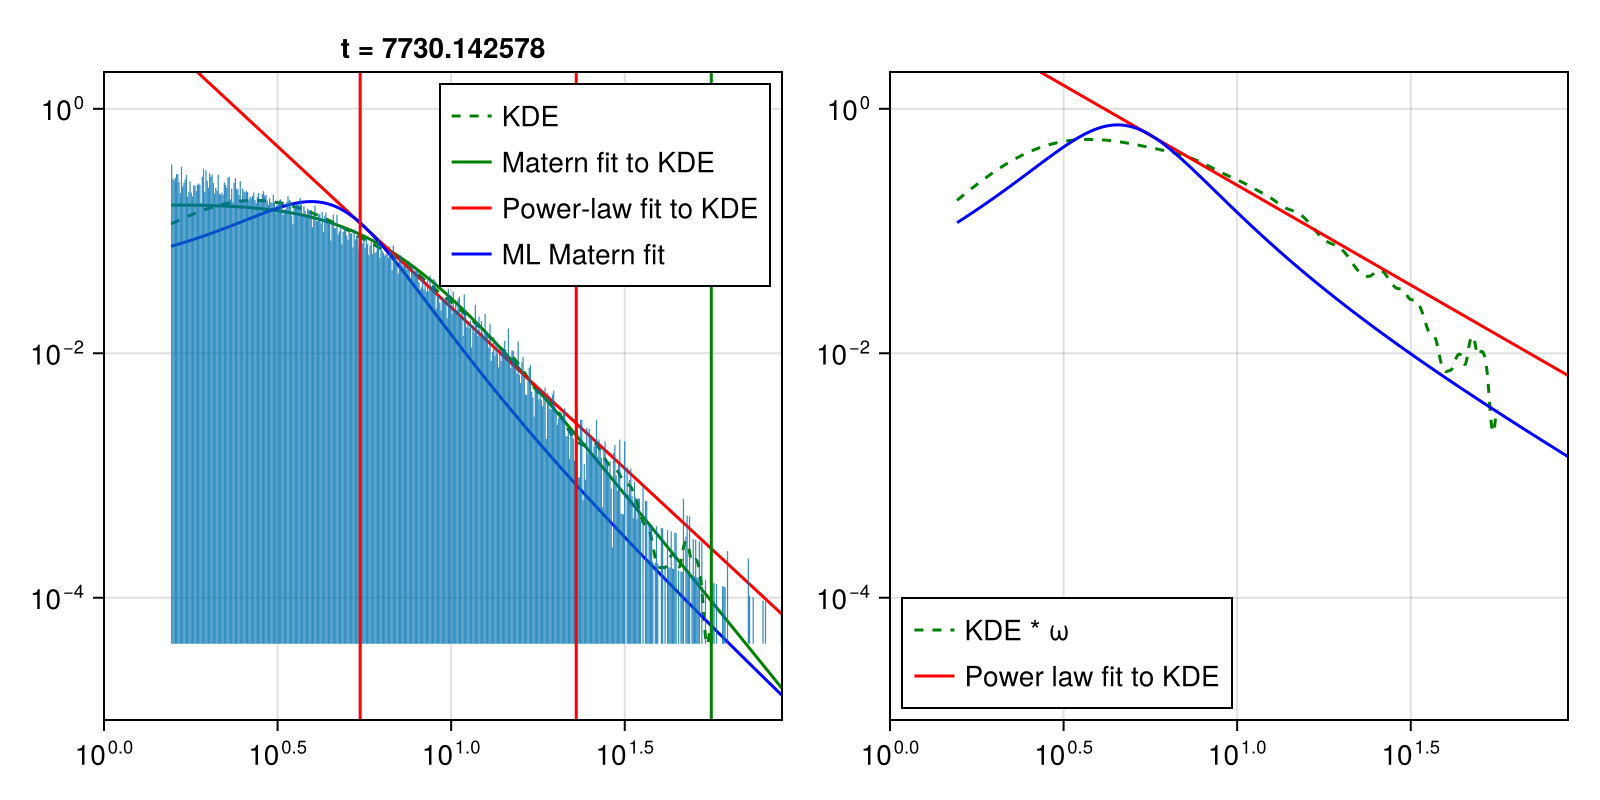

In [43]:

bins = exp.(range(log(minimum(ω)), log(maximum(ω)), length=500))
max_ω = maximum(ω)
min_ω = log(minimum(ω_i))
Δω = log(maximum(ω_i)) - min_ω
start_ω = exp(min_ω + 0.35 * Δω)
end_ω = exp(min_ω + 0.75 * Δω)

println(@sprintf("t = %0.5f", t))
println(@sprintf("RMS U = %0.5f", rms_u))
println(@sprintf("√gH = %0.5f", Cg))
println(@sprintf("Fr = %0.5f", rms_u / Cg))
println(@sprintf("KDE P. action slope: %0.5f\tEnergy slope: %0.5f",  power_law_action_fit.param[2], power_law_energy_fit.param[2]))
println(@sprintf("KDE M. action slope: %0.5f\tEnergy slope: %0.5f",  2*matern_action_fit.param[4], 2*matern_energy_fit.param[4]))
println(@sprintf("ML action slope:     %0.5f\tEnergy slope: %0.5f", -2*matern_ML_params[1], -2*matern_ML_params[1]+1))

fig3 = Figure(size=(800, 400))
ax3 = Axis(fig3[1,1], title=@sprintf("t = %f", t), xscale=log10, yscale=log10, limits=((1, max_ω), (1e-5, 2e0)))
ax4 = Axis(fig3[1,2], xscale=log10, yscale=log10, limits=((1, max_ω), (1e-5, 2e0)))

matern_pdf_func = matern_pdf(matern_ML_params...)
lines!(ax3, ω_i, kernel_estimate, color="green", linestyle=:dash, label="KDE")
lines!(ax3, full_ω_i, matern_action, color="green", label="Matern fit to KDE")
lines!(ax3, full_ω_i, power_law_action, color="red", label="Power-law fit to KDE")
lines!(ax3, full_ω_i, matern_pdf_func.(full_ω_i), color="blue", label="ML Matern fit")
    
hist!(ax3, ω, bins=bins, normalization=:pdf)
lines!(ax3, [start_ω, start_ω], [1e-6, 2], color="red")
lines!(ax3, [end_ω, end_ω], [1e-6, 2], color="red")
lines!(ax3, [cutoff_ω[end], cutoff_ω[end]], [1e-6, 2], color="green")
axislegend(ax3, position=:rt)


lines!(ax4, ω_i, kernel_estimate .* ω_i, color="green", linestyle=:dash, label="KDE * ω")
lines!(ax4, full_ω_i, matern_energy, color="green", label="Matern fit to KDE")
lines!(ax4, full_ω_i, power_law_energy, color="red", label="Power law fit to KDE")
lines!(ax4, full_ω_i, matern_pdf_func.(full_ω_i) .* full_ω_i, color="blue")
axislegend(ax4, position=:lb)

fig3

In [17]:
times
froudes
power_kde_params 
matern_kde_params
matern_ml_params 

lines(times, power_kde_params[:,:,1])

LoadError: BoundsError: attempt to access 32×2×2 Array{Float64, 3} at index [1, 1:2]

In [62]:
cutoff_index = floor(Int, Npackets * 0.9999)
sort(ω)[cutoff_index]

50.36951835094565

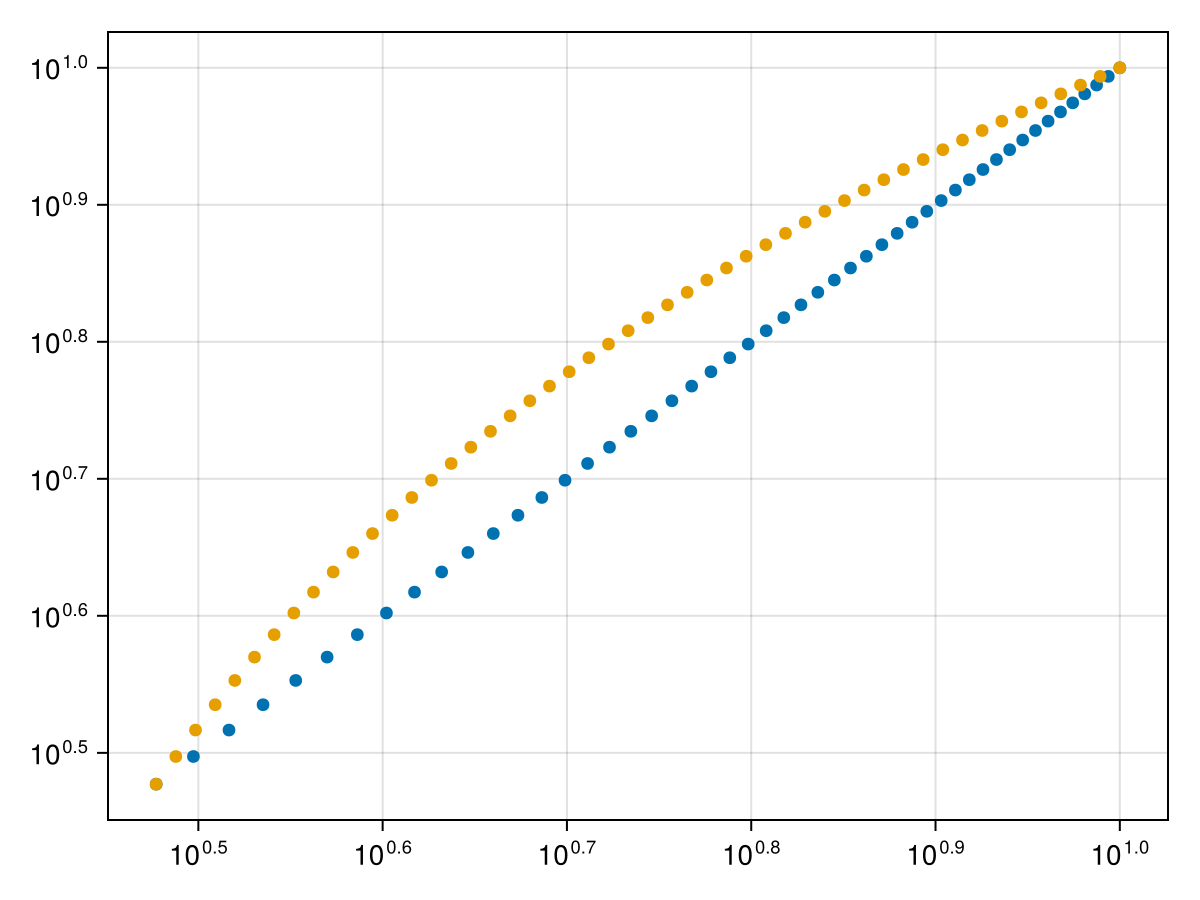

In [36]:
test_f = Figure()
test_ax = Axis(test_f[1,1]; xscale=log10, yscale=log10)

N = 50
q = (0:(N-1))/(N-1)

start = 3
fin = 10
linspace = @. start + (fin - start) * q

# exp(g(0)) = start => g(0) = log(start)
# exp(g(0)) = fin => g(1) = log(fin)
logspace = @. exp(log(start) + (log(fin) - log(start))*q)
y = @. exp(0 + (log(10)-log(1)) * log(linspace))
scatter!(test_ax, linspace, linspace)
scatter!(test_ax, logspace, linspace)

test_f